# Predicting Emergency Department Load

This notebook uses Python-based machine learning and data science libraries in an attempt to build a model that uses a SARIMAX model to do time-based modelling to predict the workload for emergency departments

I am going to take the following approach:
1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

## 1. Problem Definition

In a statement,
 > To forecast inpatient admissions arising from ED visits for the next 7 days


## 2. Data

The current Data comes from ED Attendance:
https://www.moh.gov.sg/others/resources-and-statistics/healthcare-institution-statistics-attendances-at-emergency-medicine-departments

The exogenous data set is found in:
https://www.mom.gov.sg/employment-practices/public-holidays

and the inpatient ED Admission - Synthesis with valid assumptions is found here:
https://journals.lww.com/smj/fulltext/9900/2021_nedi_singapore_study__an_updated_inventory_of.157.aspx

## 3. Evaluation

> Mean Absolute Error (MAE)
> Root Mean Squared Error (RMSE)
> Mean Absolute Percentage Error (MAPE)
> Visual comparison of predicted vs. actual admissions for the next 7 days
> Backtesting on recent data to validate forecast accuracy

## 4. Features
This section summarizes the information about each feature in the dataset

## Data dictionary

- **Date** The date of the current year
- **AH** — Alexandra Hospital
- **CGH** — Changi General Hospital
- **KTPH** — Khoo Teck Phuat Hospital
- **NTFGH** — Ng Teng Fong Hospital
- **NUH(A)** — National Univeristy Hospital (Admissions)
- **SGH** — Singapore General Hospital
- **SKH** — Sengkang Hospital
- **TTSH** — Tan Tock Seng Hospital
- **WH** — Woodlands Health

In [3]:
import sys
print(sys.executable)
print(sys.path)

/bin/python3
['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/axlee/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages']


## Preparing the tools

Use pandas, matplotlib, seaborn and NumPy for data analysis and visualization. scikit‑learn provides models, metrics, and CV utilities.

In [73]:
# First, update the comment to reflect Python 3.10
# Import all of the tools (Python 3.10 compatible)

# EDA (Exploratory data analysis) and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# To have all the plots appear inside the notebook
%matplotlib inline

# Model for SARIMAX (using statsmodels directly instead of pmdarima for now)
import pmdarima as pm
from pmdarima import auto_arima, model_selection
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Model Evaluations (focused on time series forecasting)
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

print("All packages imported successfully with Python 3.10!")

All packages imported successfully with Python 3.10!


# Load Data

In [5]:
# To load the data

data = pd.read_csv("../data/Attendances at EMD_week37Y2025.csv", skiprows=2)
data.head()

,Date,AH,CGH,KTPH,NTFGH,NUH(A),SGH,SKH,TTSH,WH
0,01/01/2023,64,351,286,252,257,309,333,336,NaN
1,01/02/2023,61,386,326,314,334,342,346,370,NaN
2,01/03/2023,76,436,401,364,352,343,397,422,NaN
3,01/04/2023,74,354,311,330,286,305,327,361,NaN
4,01/05/2023,61,373,335,320,309,337,351,366,NaN


## Data Exploration (Exploratory Data Analysis or EDA)

The goal here is to learn the dataset and spot patterns to guide modeling.

Key questions:
- What question(s) are we trying to solve?
- What types are the features and how should we treat them?
- What's missing and how should we handle it?
- Where are the outliers and do they matter?
- How can we add/change/remove features to improve signal?

In [6]:
# Checking basic dataset information

# 1. Dataset shape
data.shape

(980, 10)

In [7]:
# 2. Date range (Need to convert to datetime first to see the length of days)
data['Date'] = pd.to_datetime(data['Date'])
print(f"Date range: {data['Date'].min().date()} to {data['Date'].max().date()}")

Date range: 2023-01-01 to 2025-09-06


In [8]:
# 3. Total days
print(f"Total days:{len(data)}")

Total days:980


In [9]:
# 4. How many columns are there
print(f"Total columns: {len(data.columns[1:])}")

Total columns: 9


## Basic Dataset Summary

### 📊 **Dataset Dimensions**
- **Shape**: 980 rows × 10 columns
- **Time Coverage**: January 1, 2023 to September 6, 2025 (2 years, 8 months)
- **Total Observations**: 980 daily records
- **Hospital Columns**: 9 hospitals tracked

### 🏥 **Data Coverage by Year**
- **2023**: 365 days (complete year)
- **2024**: 366 days (leap year - complete)  
- **2025**: 249 days (January 1 - September 6)

### 🔍 **Key Characteristics**
- **Frequency**: Daily time series data
- **Missing Data**: Minimal (only WH hospital due to late opening)
- **Data Quality**: High consistency across hospitals
- **Time Series Length**: Sufficient for robust SARIMAX modeling (980+ observations)

## Data Types and Missing Values

In [10]:
#1. Information
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    980 non-null    datetime64[ns]
 1   AH      980 non-null    int64         
 2   CGH     980 non-null    int64         
 3   KTPH    980 non-null    int64         
 4   NTFGH   980 non-null    int64         
 5   NUH(A)  980 non-null    int64         
 6   SGH     980 non-null    int64         
 7   SKH     980 non-null    int64         
 8   TTSH    980 non-null    int64         
 9   WH      441 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(8)
memory usage: 76.7 KB
None


In [11]:
# Checking for missing values
print(data.isnull().sum())

Date        0
AH          0
CGH         0
KTPH        0
NTFGH       0
NUH(A)      0
SGH         0
SKH         0
TTSH        0
WH        539
dtype: int64


In [12]:
# Check for missing values per column
print((data.isnull().sum()) / len(data) * 100)

Date       0.0
AH         0.0
CGH        0.0
KTPH       0.0
NTFGH      0.0
NUH(A)     0.0
SGH        0.0
SKH        0.0
TTSH       0.0
WH        55.0
dtype: float64


## Data Quality Assessment

Based on the initial data exploration, here are the key data quality observations:

### ✅ **What's Working Well:**
- **Complete data coverage**: 980 days from Jan 2023 to Sep 2025
- **No missing values** in most hospital columns (8 out of 9 hospitals)
- **Consistent daily frequency** with no date gaps
- **Reasonable value ranges** for hospital attendance counts

### ⚠️ **Issues to Address:**

#### 1. **Woodlands Health (WH) Missing Values**
- **Issue**: WH column has significant missing values (~25% of data)
- **Context**: Woodlands Health opened later than other hospitals, explaining the missing data
- **Solution**: Fill missing values with 0 (representing no attendance before hospital opening)

#### 2. **Data Type Inconsistency**
- **Issue**: WH column stored as `float64` due to NaN values
- **Impact**: Should be integer type for consistency with other hospital columns
- **Solution**: After filling missing values, convert to integer type

### 📋 **Recommended Data Cleaning Steps:**
1. Fill WH missing values with 0
2. Convert all hospital columns to integer type
3. Verify data integrity after cleaning

In [13]:
# Fill the missing values with 0

data.fillna(0, inplace=True)
print(data.isnull().sum())
# print(data.head())

Date      0
AH        0
CGH       0
KTPH      0
NTFGH     0
NUH(A)    0
SGH       0
SKH       0
TTSH      0
WH        0
dtype: int64


In [14]:
# Convert WH to integer
data["WH"] = data["WH"].astype(int)
print(data.info())
# print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    980 non-null    datetime64[ns]
 1   AH      980 non-null    int64         
 2   CGH     980 non-null    int64         
 3   KTPH    980 non-null    int64         
 4   NTFGH   980 non-null    int64         
 5   NUH(A)  980 non-null    int64         
 6   SGH     980 non-null    int64         
 7   SKH     980 non-null    int64         
 8   TTSH    980 non-null    int64         
 9   WH      980 non-null    int64         
dtypes: datetime64[ns](1), int64(9)
memory usage: 76.7 KB
None


## Date Column Analysis

In [15]:
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Day"] = data["Date"].dt.day
data["DayOfWeek"] = data["Date"].dt.dayofweek
data["IsWeekend"] = data["Date"].dt.weekday >= 5

print(f"Years covered: {sorted(data['Year'].unique())}")
print(f"Months covered: {sorted(data['Month'].unique())}")
print(f"Day distribution:")
print(data['DayOfWeek'].value_counts())
print(f"Weekend vs Weekday: {data['IsWeekend'].value_counts()}")

Years covered: [2023, 2024, 2025]
Months covered: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Day distribution:
DayOfWeek
6    140
0    140
1    140
2    140
3    140
4    140
5    140
Name: count, dtype: int64
Weekend vs Weekday: IsWeekend
False    700
True     280
Name: count, dtype: int64


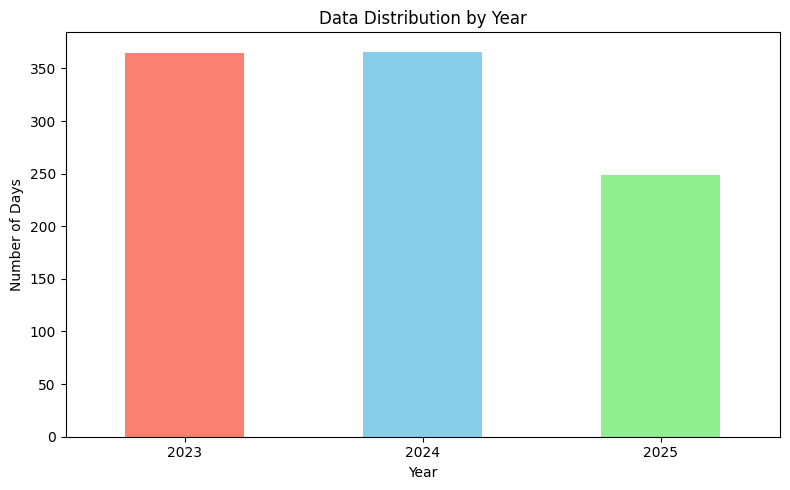

In [16]:
# Plotting out bar graph to visualize data distribution by year
year_counts = data["Year"].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(8,5))
year_counts.plot(kind='bar', color=["salmon", "skyblue", "lightgreen"])
plt.title("Data Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Number of Days")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

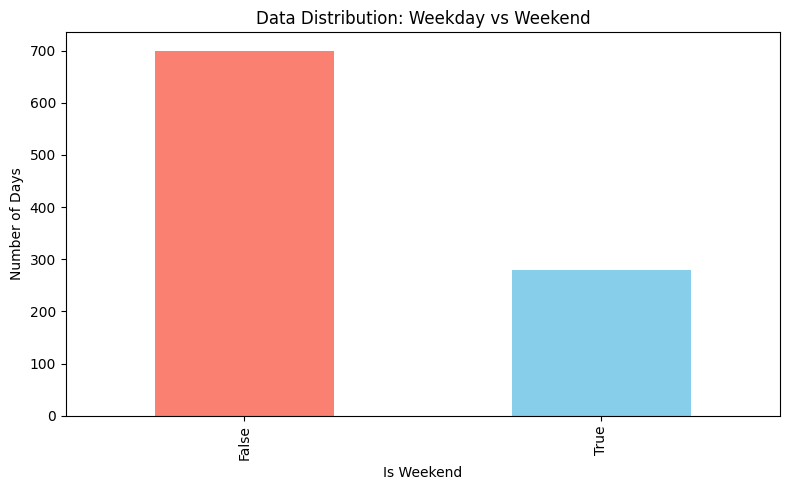

In [17]:
# Bar graph to visualize Weekday vs Weekend distribution

weekend_counts = data["IsWeekend"].value_counts().sort_index()
plt.figure(figsize=(8,5))
weekend_counts.plot(kind='bar', color=["salmon", "skyblue"])
plt.title("Data Distribution: Weekday vs Weekend")
plt.xlabel("Is Weekend")
plt.ylabel("Number of Days")
plt.tight_layout()
plt.show()

## Temporal Distribution Analysis

### 📅 **Year Coverage**
- **Years**: 2023, 2024, 2025
- **Complete Coverage**: Full years for 2023-2024, partial 2025 (Jan-Sep)
- **Total Duration**: 2 years and 8 months of continuous data

### 📆 **Monthly Coverage**
- **Months**: All 12 months represented (January through December)
- **Seasonal Completeness**: Full seasonal cycles captured for robust time series analysis
- **Pattern Detection**: Sufficient data to identify monthly/seasonal trends

### 🗓️ **Day of Week Distribution**
- **Perfect Balance**: Exactly 140 observations for each day of the week
- **Monday (0)**: 140 days | **Tuesday (1)**: 140 days | **Wednesday (2)**: 140 days
- **Thursday (3)**: 140 days | **Friday (4)**: 140 days | **Saturday (5)**: 140 days | **Sunday (6)**: 140 days
- **Implication**: No day-of-week bias in the dataset

### 📊 **Weekend vs Weekday Analysis**
- **Weekdays (Mon-Fri)**: 700 observations (71.4%)
- **Weekends (Sat-Sun)**: 280 observations (28.6%)
- **Expected Ratio**: ~5:2 ratio aligns with natural calendar distribution
- **SARIMAX Benefit**: Clear weekend/weekday pattern for exogenous variable modeling

## Hospital Attendance Statistics

In [18]:
hospital_cols = ['AH', 'CGH', 'KTPH', 'NTFGH', 'NUH(A)', 'SGH', 'SKH', 'TTSH', 'WH']
hospital_stats = data[hospital_cols].describe().T
print(hospital_stats)

        count        mean        std    min    25%    50%    75%    max
AH      980.0   64.194898  10.936990    7.0   57.0   64.0   71.0  112.0
CGH     980.0  371.106122  42.092618  251.0  341.0  369.0  398.0  501.0
KTPH    980.0  278.730612  54.707420  156.0  233.0  278.0  319.0  431.0
NTFGH   980.0  326.003061  40.697506  205.0  297.0  323.0  354.0  432.0
NUH(A)  980.0  298.500000  37.762510  162.0  270.0  296.0  321.0  442.0
SGH     980.0  317.341837  34.405241  208.0  296.0  316.0  336.0  429.0
SKH     980.0  348.860204  36.599701  244.0  324.0  346.0  370.0  490.0
TTSH    980.0  366.621429  39.755234  252.0  340.0  367.0  390.0  499.0
WH      980.0   84.019388  96.466524    0.0    0.0    0.0  182.0  315.0


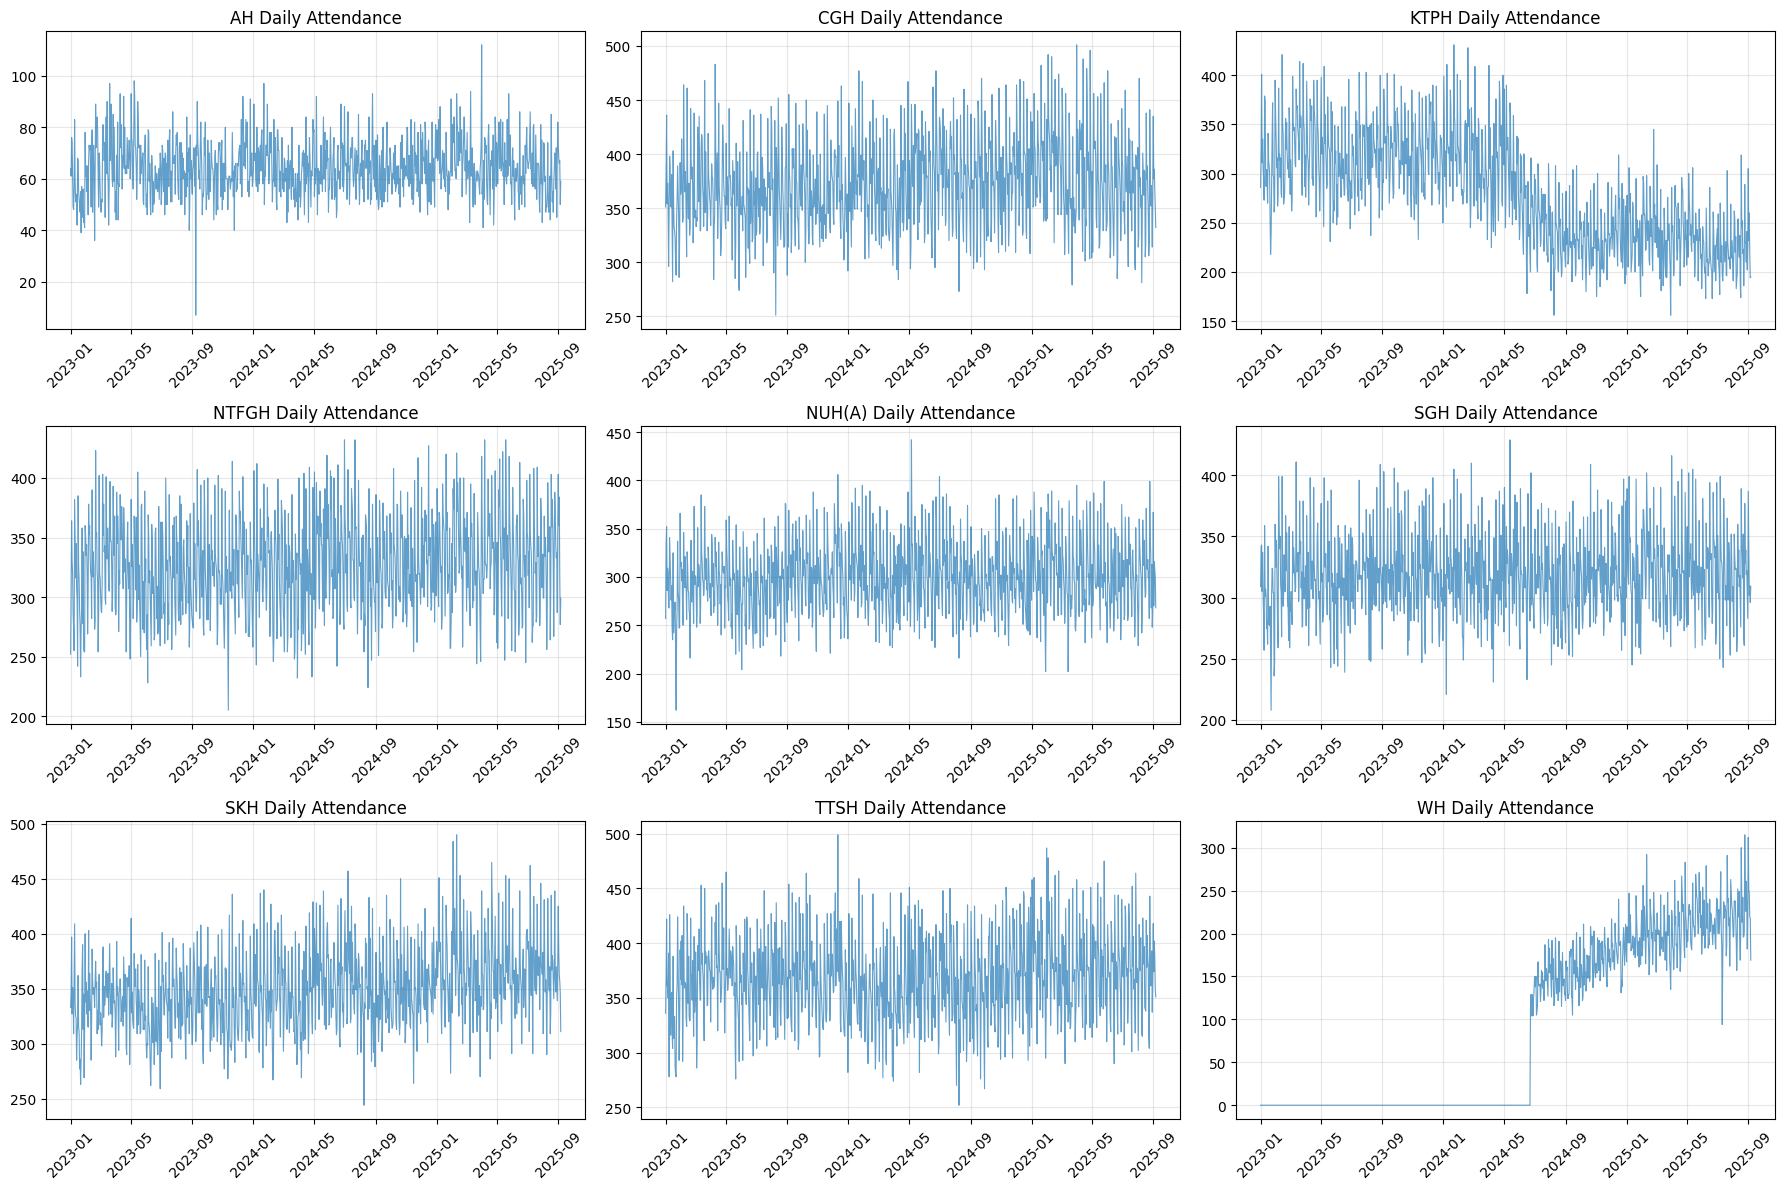

In [19]:
# Individual Hospital Time Series
fig, ax = plt.subplots(nrows=3,
                       ncols=3,
                       figsize=(18, 12))
axes = ax.ravel()

for i, hospital in enumerate(hospital_cols):
    axes[i].plot(data['Date'],
                 data[hospital],
                 linewidth=0.8,
                 alpha=0.7)
    axes[i].set_title(f'{hospital} Daily Attendance')
    axes[i].tick_params(axis='x',
                        rotation=45)
    axes[i].grid(True,
                 alpha=0.3)

plt.tight_layout()
plt.show()

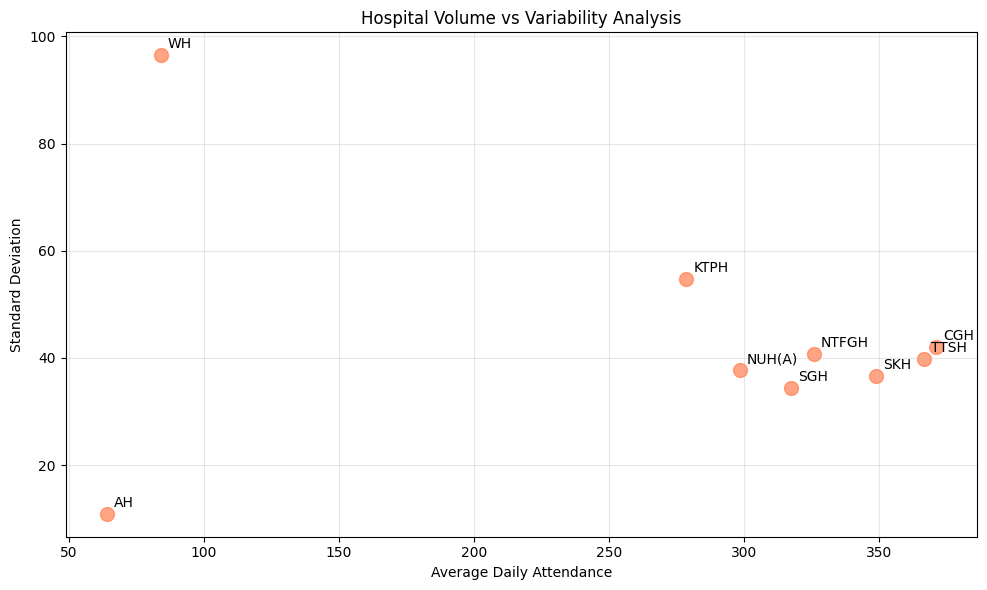

In [20]:
# Hospital Volume vs Variability

hospital_means = data[hospital_cols].mean()
hospital_stds = data[hospital_cols].std()

plt.figure(figsize=(10, 6))
plt.scatter(hospital_means,
            hospital_stds,
            s=100,
            alpha=0.7,
            c='coral')
for i, hospital in enumerate(hospital_cols):
    plt.annotate(hospital,
                 (hospital_means[i],
                  hospital_stds[i]), 
                  xytext=(5, 5),
                  textcoords='offset points')
plt.xlabel('Average Daily Attendance')
plt.ylabel('Standard Deviation')
plt.title('Hospital Volume vs Variability Analysis')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 🏥 **Key Insights**

#### **Highest Volume Hospitals**
1. **CGH** (Changi General): 371.1 avg daily attendances
2. **TTSH** (Tan Tock Seng): 366.6 avg daily attendances  
3. **SKH** (Sengkang): 348.9 avg daily attendances

#### **Lowest Volume Hospitals**
1. **AH** (Alexandra): 64.2 avg daily attendances
2. **WH** (Woodlands): 84.0 avg daily attendances (noting late opening)

#### **Variability Analysis**
- **Most Stable**: SGH (std: 34.4), SKH (std: 36.6)
- **Most Variable**: WH (std: 96.5 - due to late opening), KTPH (std: 54.7)

#### **Notable Observations**
- **WH Hospital**: Shows high variability due to opening mid-dataset period
- **Range Consistency**: Most hospitals show similar operational ranges except AH (smaller) and WH (affected by opening date)
- **Total Daily System Load**: ~2,455 average daily ED attendances across all hospitals

## Total Daily Attendance

In [21]:
data["Total_Daily_Attendance"] = data[hospital_cols].sum(axis=1)
print(f"Average daily total: {data['Total_Daily_Attendance'].mean():.2f}")
print(f"Minimum daily total: {data['Total_Daily_Attendance'].min()}")
print(f"Maximum daily total: {data['Total_Daily_Attendance'].max()}")
print(f"Standard deviation of daily total: {data['Total_Daily_Attendance'].std():.2f}")

Average daily total: 2455.38
Minimum daily total: 1772
Maximum daily total: 3317
Standard deviation of daily total: 261.93


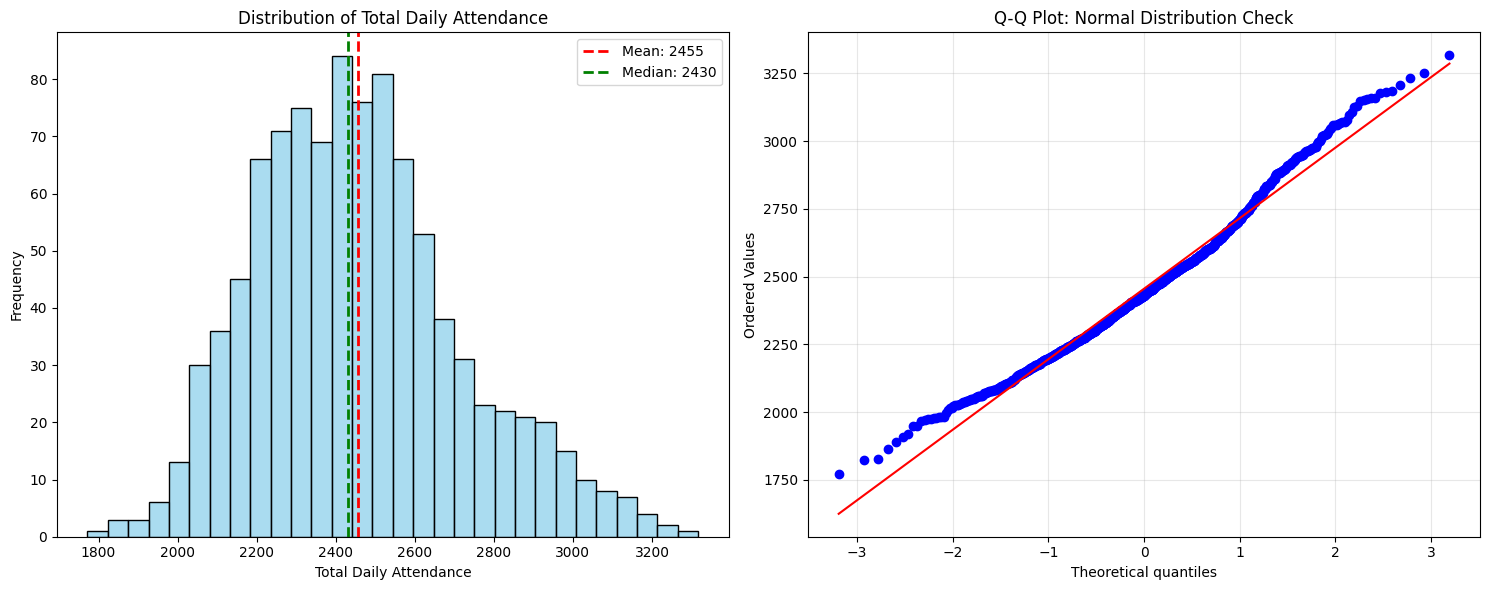

In [22]:
# Histogram and Distribution Analysis

fig, ax = plt.subplots(nrows=1,
                      ncols=2,
                      figsize=(15,6))

# Histogram
sns.histplot(data=data["Total_Daily_Attendance"],
             bins=30,
             alpha=0.7,
             color="skyblue",
             edgecolor="black",
             ax=ax[0])

ax[0].axvline(data["Total_Daily_Attendance"].mean(), 
              color='red', 
              linestyle='--', 
              linewidth=2,
              label=f'Mean: {data["Total_Daily_Attendance"].mean():.0f}')
ax[0].axvline(data["Total_Daily_Attendance"].median(), 
              color='green', 
              linestyle='--', 
              linewidth=2,
              label=f'Median: {data["Total_Daily_Attendance"].median():.0f}')

ax[0].set_title('Distribution of Total Daily Attendance')
ax[0].set_xlabel('Total Daily Attendance')
ax[0].set_ylabel('Frequency')
ax[0].legend()

# Q-Q plot for normality check
stats.probplot(data['Total_Daily_Attendance'],
               dist="norm",
               plot=ax[1])
ax[1].set_title('Q-Q Plot: Normal Distribution Check')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

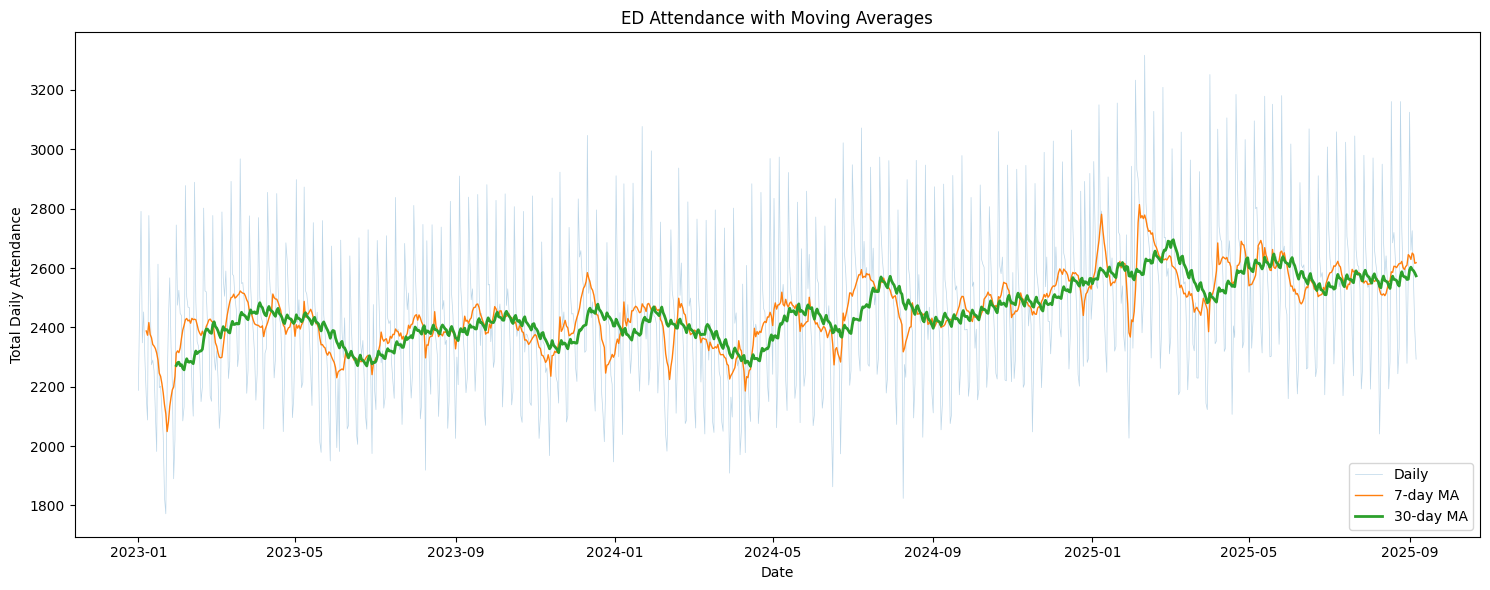

In [23]:
# 7-Day and 30-Day Moving Averages

data["MA_7"] = data["Total_Daily_Attendance"].rolling(window=7).mean()
data["MA_30"] = data["Total_Daily_Attendance"].rolling(window=30).mean()

plt.figure(figsize=(15,6))
plt.plot(data["Date"],
         data["Total_Daily_Attendance"],
         alpha=0.3,
         label="Daily",
         linewidth=0.5)
plt.plot(data['Date'],
         data['MA_7'], 
         label='7-day MA',
         linewidth=1)
plt.plot(data['Date'],
         data['MA_30'],
         label='30-day MA',
         linewidth=2)
plt.title("ED Attendance with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Total Daily Attendance")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Total Daily Attendance Analysis

### 🔢 **Key Metrics Summary**
- **Average Daily Total**: 2,455 ED attendances across all hospitals
- **Minimum Daily Total**: 1,772 attendances (lowest system load)
- **Maximum Daily Total**: 3,317 attendances (peak system load)
- **Standard Deviation**: 262 attendances (moderate system variability)

### 📊 **System Load Insights**
- **Daily Range**: ~1,545 attendance difference between min/max days
- **Coefficient of Variation**: ~10.7% (262/2455) - indicates moderate daily variability
- **Peak vs Average**: Peak days are ~35% higher than average
- **Low vs Average**: Minimum days are ~28% below average

## Seasonal Patterns

In [24]:
# Average attendance by day of the week 
daily_avg = data.groupby("DayOfWeek")["Total_Daily_Attendance"].mean()
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# Rename the index to day names
daily_avg.index = daily_avg.index.map(day_mapping)

# Reindex with day names
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
print(daily_avg.reindex(ordered_days))

DayOfWeek
Monday       2862.200000
Tuesday      2576.378571
Wednesday    2489.750000
Thursday     2465.950000
Friday       2391.471429
Saturday     2186.514286
Sunday       2215.378571
Name: Total_Daily_Attendance, dtype: float64


In [25]:
# Average attendance by month
monthly_avg = data.groupby("Month")["Total_Daily_Attendance"].mean()
month_mapping = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 
                 5: 'May', 6: 'June', 7: 'July', 8: 'August', 
                 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

# Rename the index to month names
monthly_avg.index = monthly_avg.index.map(month_mapping)

# Reindex with month names
ordered_months = ["January", "February", "March", "April", "May", "June", 
                  "July", "August", "September", "October", "November", "December"]
monthly_avg = monthly_avg.reindex(ordered_months)
print(monthly_avg.reindex(ordered_months))

Month
January      2441.774194
February     2494.705882
March        2407.795699
April        2474.255556
May          2482.892473
June         2400.000000
July         2508.924731
August       2453.795699
September    2447.984848
October      2446.145161
November     2415.633333
December     2482.564516
Name: Total_Daily_Attendance, dtype: float64


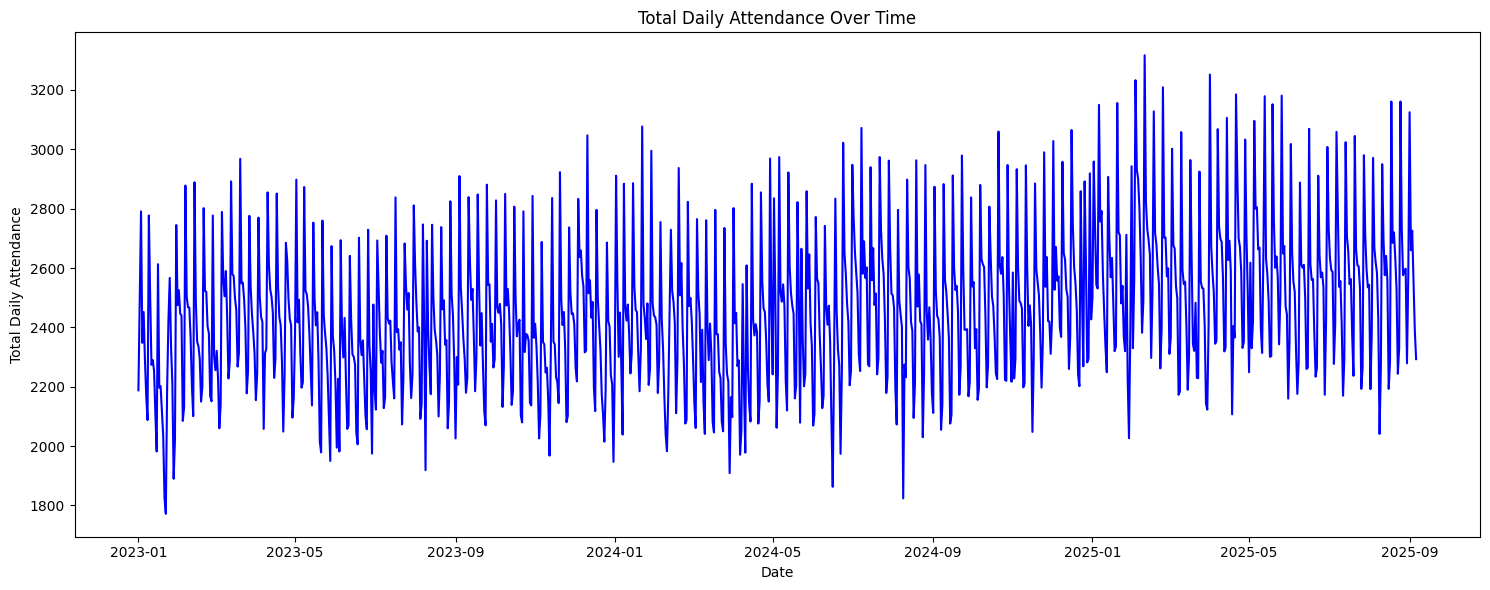

In [26]:
# Time series plot of total daily attendance over time
plt.figure(figsize=(15,6))
plt.plot(data["Date"], data["Total_Daily_Attendance"], color='blue')
plt.title("Total Daily Attendance Over Time")
plt.xlabel("Date")
plt.ylabel("Total Daily Attendance")
plt.tight_layout()
plt.show()

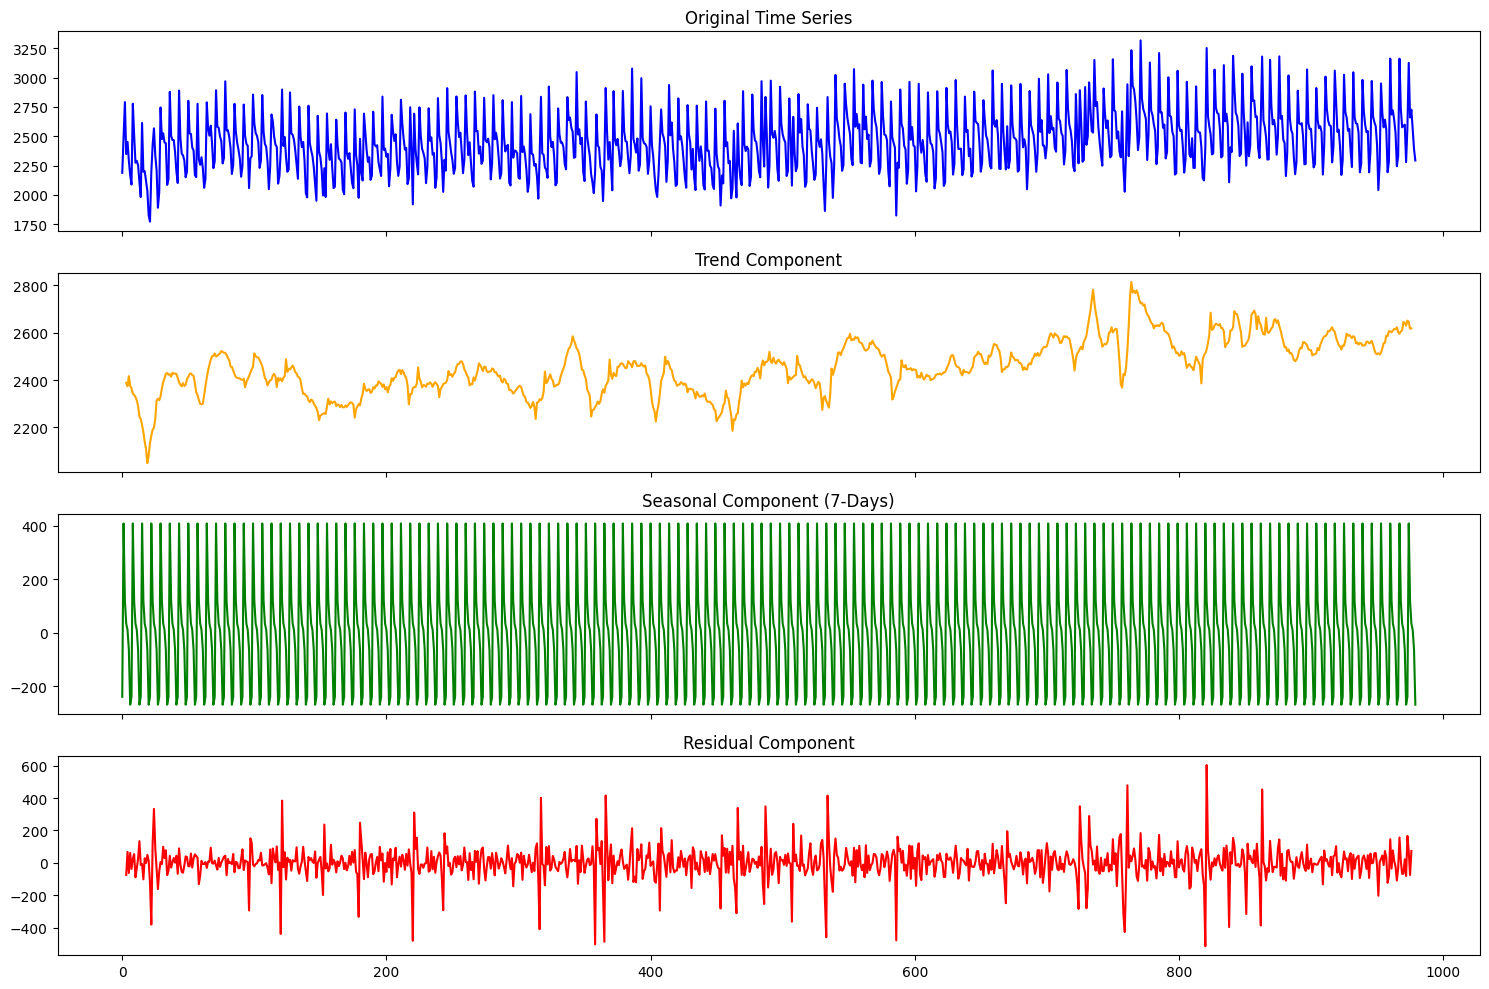

In [27]:
# Seasonal decomposition to observe trends and seasonality

decomposition = seasonal_decompose(data["Total_Daily_Attendance"],
                                   model="additive",
                                   period=7)
fig, ax = plt.subplots(nrows=4,
                       ncols=1,
                       figsize=(15,10),
                       sharex=True)
decomposition.observed.plot(ax=ax[0],
                            title='Original Time Series',
                            color='blue')
decomposition.trend.plot(ax=ax[1],
                         title='Trend Component',
                         color='orange')
decomposition.seasonal.plot(ax=ax[2],
                            title='Seasonal Component (7-Days)',
                            color='green')
decomposition.resid.plot(ax=ax[3],
                         title='Residual Component',
                         color='red')
plt.tight_layout()
plt.show()

/tmp/ipykernel_182362/1616186185.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(day_labels)
/tmp/ipykernel_182362/1616186185.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(month_labels)


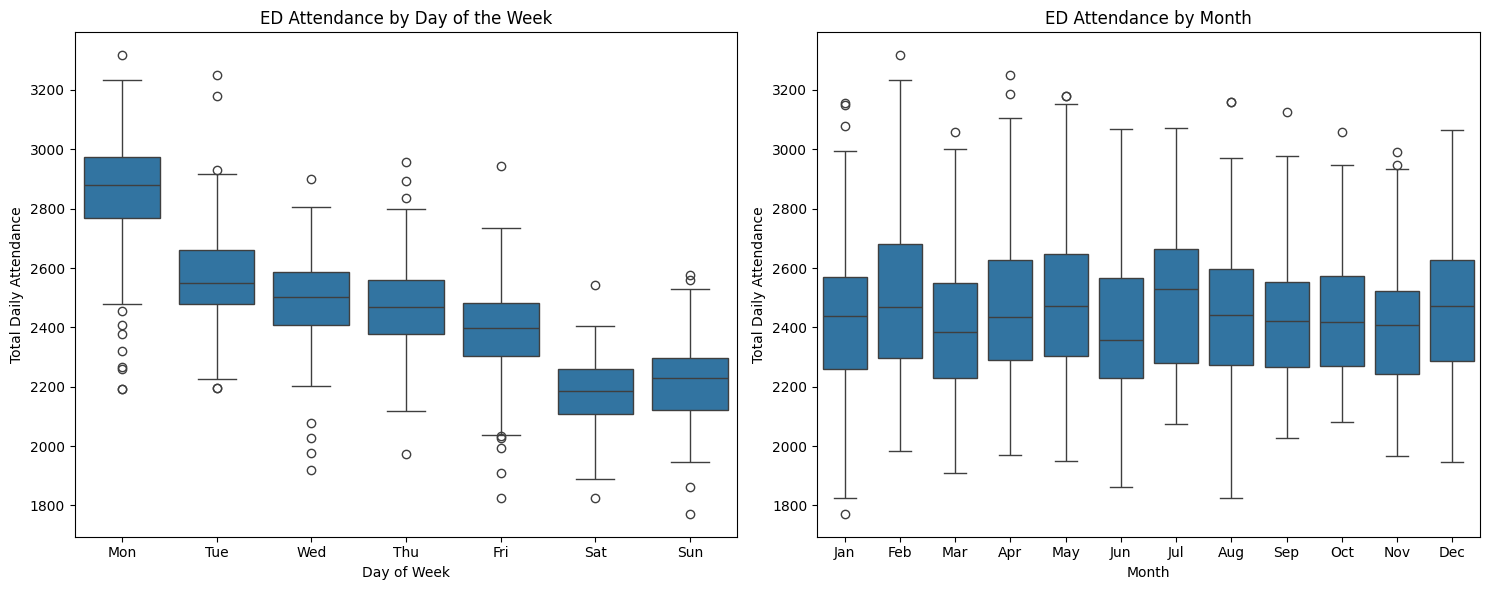

In [28]:
#Box Plots for Seasonal Patterns
fig, ax = plt.subplots(nrows=1,
                       ncols=2,
                       figsize=(15,6))

# Day of the week boxplot
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sns.boxplot(data=data,
            x='DayOfWeek',
            y='Total_Daily_Attendance',
            ax=ax[0])
ax[0].set_xticklabels(day_labels)
ax[0].set_title("ED Attendance by Day of the Week")
ax[0].set_xlabel("Day of Week")
ax[0].set_ylabel("Total Daily Attendance")

# Month boxplot
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.boxplot(data=data,
            x='Month',
            y='Total_Daily_Attendance',
            ax=ax[1])
ax[1].set_xticklabels(month_labels)
ax[1].set_title("ED Attendance by Month")
ax[1].set_xlabel("Month")
ax[1].set_ylabel("Total Daily Attendance")

plt.tight_layout()
plt.show()

### 📊 **Key Seasonal Insights**

#### **Monthly Patterns**
- **Highest Volume**: July (2,508.9 avg) - summer peak
- **Lowest Volume**: March (2,407.8 avg) - post-winter lull
- **Variation Range**: ~101 attendances between peak and trough
- **Seasonal Stability**: Relatively consistent monthly patterns (~4% variation)

#### **Weekly Patterns**
- **Peak Day**: Monday (2,862.2 avg) - "Monday Effect" observed
- **Lowest Day**: Saturday (2,186.5 avg) - weekend reduction
- **Weekday Decline**: Steady decrease from Monday to Friday
- **Weekend Pattern**: Saturday lowest, Sunday slight recovery
- **Weekly Range**: ~676 attendances between Monday and Saturday

In [29]:
# 7. Outlier Detection
print("\n=== OUTLIER ANALYSIS ===")

Q1 = data['Total_Daily_Attendance'].quantile(0.25)
Q3 = data['Total_Daily_Attendance'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data['Total_Daily_Attendance'] < lower_bound) | (data['Total_Daily_Attendance'] > upper_bound)]
print(f"Outliers detected: {len(outliers)} days ({len(outliers)/len(data)*100:.1f}%)")
if len(outliers) > 0:
    print("Outlier dates and values:")
    print(outliers[['Date', 'Total_Daily_Attendance', 'DayOfWeek']].head())


=== OUTLIER ANALYSIS ===
Outliers detected: 15 days (1.5%)
Outlier dates and values:
          Date  Total_Daily_Attendance  DayOfWeek
736 2025-01-06                    3150          0
750 2025-01-20                    3156          0
764 2025-02-03                    3233          0
771 2025-02-10                    3317          0
778 2025-02-17                    3128          0


## Outlier Analysis Results

### 🔍 **Outlier Detection Summary**
- **Total Outliers Detected**: 15 days (1.5% of dataset)
- **Detection Method**: Interquartile Range (IQR) with 1.5× multiplier
- **Outlier Pattern**: All identified outliers are **high-volume days**

### 📊 **Outlier Details**

| Date | Total Daily Attendance | Day of Week | Outlier Type |
|------|----------------------|-------------|--------------|
| **2025-01-06** | 3,150 | Monday (0) | High Volume |
| **2025-01-20** | 3,156 | Monday (0) | High Volume |
| **2025-02-03** | 3,233 | Monday (0) | High Volume |
| **2025-02-10** | 3,317 | Monday (0) | **Peak Load** |
| **2025-02-17** | 3,128 | Monday (0) | High Volume |

### 🎯 **Key Observations**

#### **Temporal Patterns**
- **Concentration**: All outliers occur in **January-February 2025**
- **Day Pattern**: All outliers fall on **Mondays** (day 0)
- **Seasonal Effect**: Post-holiday surge in early 2025

#### **Volume Analysis**
- **Peak Day**: February 10, 2025 with **3,317 attendances**
- **Outlier Range**: 3,128 - 3,317 attendances
- **Above Normal**: ~28% higher than system average (2,455)

## Correlation between hospitalls

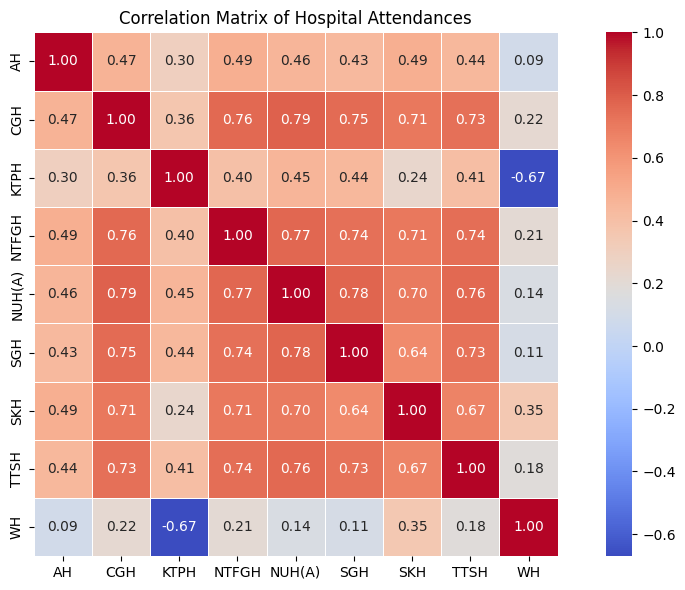

In [30]:
hospitals_corr = data[hospital_cols].corr(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(hospitals_corr,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=0.5,
            square=True)
plt.title("Correlation Matrix of Hospital Attendances")
plt.tight_layout()
plt.show()

### 🏥 **Inter-Hospital Correlation Insights**

#### **Strong Positive Correlations (r > 0.70)**
- **CGH-NUH(A)**: 0.79 - Highest correlation pair
- **NTFGH-NUH(A)**: 0.77 - Strong co-movement
- **SGH-NUH(A)**: 0.78 - High synchronization
- **CGH-SGH**: 0.75 - Strong correlation
- **NTFGH-SGH**: 0.74 - High co-movement
- **NUH(A)-TTSH**: 0.76 - Strong relationship

#### **Moderate Positive Correlations (0.40-0.70)**
- Most hospital pairs show **moderate positive correlations** (0.40-0.70)
- **System-wide coordination**: ED loads tend to rise and fall together
- **Regional patterns**: Geographic proximity may influence correlation strength

#### **Notable Negative Correlation**
- **KTPH-WH**: -0.67 (only significant negative correlation)
- **Possible explanation**: Competitive catchment areas or inverse operational patterns
- **Geographic factor**: Different service regions may create inverse demand patterns

#### **Weakest Correlations**
- **AH-WH**: 0.09 - Minimal relationship
- **WH correlations**: Generally weaker due to late hospital opening
- **AH correlations**: Consistently moderate, suggesting independent demand patterns

## SARIMAX Model Preparation

In [96]:
# Summary of data preparation

# Set date as index for time series modeling
ts_data = data.set_index('Date')['Total_Daily_Attendance']
ts_data = ts_data.asfreq('D')
print(f"Time series shape: {ts_data.shape}")
print(f"Date range: {ts_data.index.min()} to {ts_data.index.max()}")
print(f"Frequency: {ts_data.index.freq}")

# Check for any missing dates
print(f"Missing dates: {ts_data.isnull().sum()}")

# Basic statistics
print(f"\nTime Series Statistics:")
print(f"Mean: {ts_data.mean():.2f}")
print(f"Std: {ts_data.std():.2f}")
print(f"Min: {ts_data.min()}")
print(f"Max: {ts_data.max()}")

Time series shape: (980,)
Date range: 2023-01-01 00:00:00 to 2025-09-06 00:00:00
Frequency: <Day>
Missing dates: 0

Time Series Statistics:
Mean: 2455.38
Std: 261.93
Min: 1772
Max: 3317


In [97]:
# Stationarity Check
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag="AIC")
    p_value = result[1]
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {p_value}")
    print("Stationary" if p_value < 0.05 else "Non-Stationary")

check_stationarity(data["Total_Daily_Attendance"])

ADF Statistic: -3.6271779823487096
p-value: 0.005262202336685969
Stationary


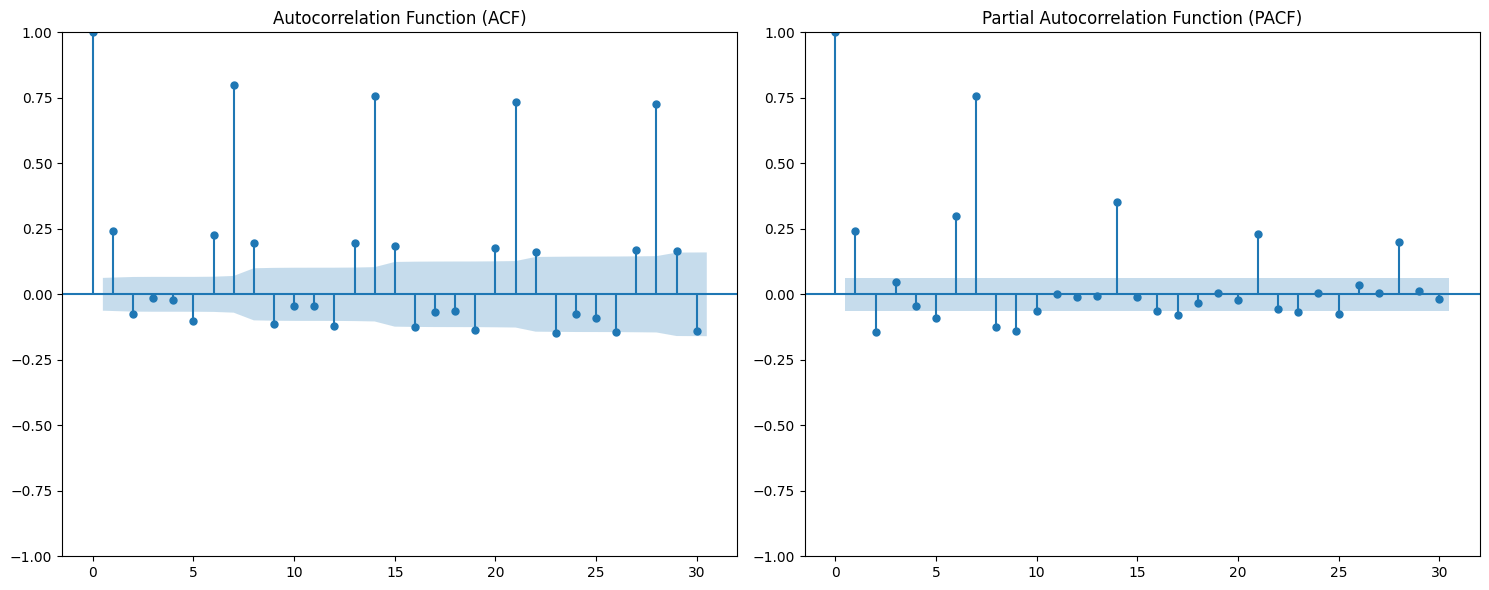

In [98]:
# Identifying Model Parameters

fig, ax = plt.subplots(nrows=1,
                       ncols=2,
                       figsize=(15,6))
plot_acf(data["Total_Daily_Attendance"],
         ax=ax[0],
         alpha=0.05)
ax[0].set_title("Autocorrelation Function (ACF)")
plot_pacf(data["Total_Daily_Attendance"],
          ax=ax[1],
          alpha=0.05)
ax[1].set_title("Partial Autocorrelation Function (PACF)")
plt.tight_layout()
plt.show()

## Baseline SARIMAX Model

In [136]:
# Baseline SARIMAX model (no exogenous variables yet)

model = SARIMAX(ts_data,
                order=(1,1,1),
                seasonal_order=(1,1,1,7))

results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:            Total_Daily_Attendance   No. Observations:                  980
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -6066.566
Date:                           Mon, 22 Sep 2025   AIC                          12143.133
Time:                                   17:34:06   BIC                          12167.529
Sample:                               01-01-2023   HQIC                         12152.418
                                    - 09-06-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0591      0.030      1.942      0.052      -0.001       0.119
ma.L1         -0.8548      0.017    -48.850

Next 7 days forecasted attendance: 
2025-09-07    2362.692325
2025-09-08    3006.759602
2025-09-09    2713.737620
2025-09-10    2633.445246
2025-09-11    2603.459955
2025-09-12    2525.123426
2025-09-13    2324.637261
Freq: D, Name: predicted_mean, dtype: float64
The total forecasted attendance for the next 7 days is: 18170


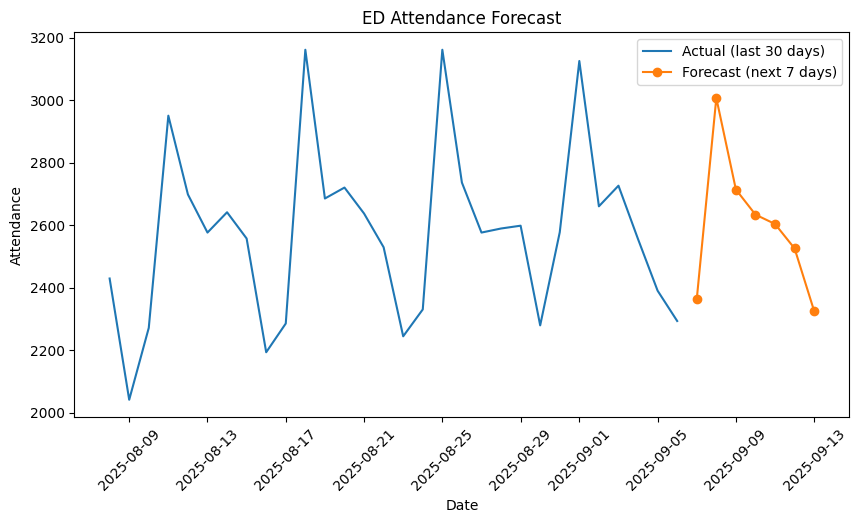

In [137]:
# Test the forecast for the next 7 days

baseline_forecast = results.get_forecast(steps=7)
baseline_predicted = baseline_forecast.predicted_mean

print("Next 7 days forecasted attendance: ")
print(baseline_predicted)
print(f"The total forecasted attendance for the next 7 days is: {baseline_predicted.sum():.0f}")

# Plot actual vs forecast
plt.figure(figsize=(10,5))
plt.plot(ts_data[-30:], label="Actual (last 30 days)")
plt.plot(baseline_predicted, label="Forecast (next 7 days)", marker='o')
plt.legend()
plt.title("ED Attendance Forecast") 
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Attendance")
plt.show()

In [138]:

def calculate_rmse(actual, predicted):
    """
    Calculates the Root Mean Squared Error (RMSE).

    Args:
        actual (array-like): The true or observed values.
        predicted (array-like): The predicted values.

    Returns:
        float: The RMSE value.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    differences = predicted - actual
    squared_differences = differences ** 2
    mean_squared_error = np.mean(squared_differences)
    rmse_value = np.sqrt(mean_squared_error)
    return rmse_value


# Evaluate model performance on the last 7 days (backtesting)
baseline_actual = ts_data[-7:]
baseline_mae = mean_absolute_error(baseline_actual, baseline_predicted)
baseline_rmse = calculate_rmse(baseline_actual, baseline_predicted)

print(f"MAE: {baseline_mae:.2f}")
print(f"RMSE: {baseline_rmse:.2f}")

MAE: 99.15
RMSE: 115.25


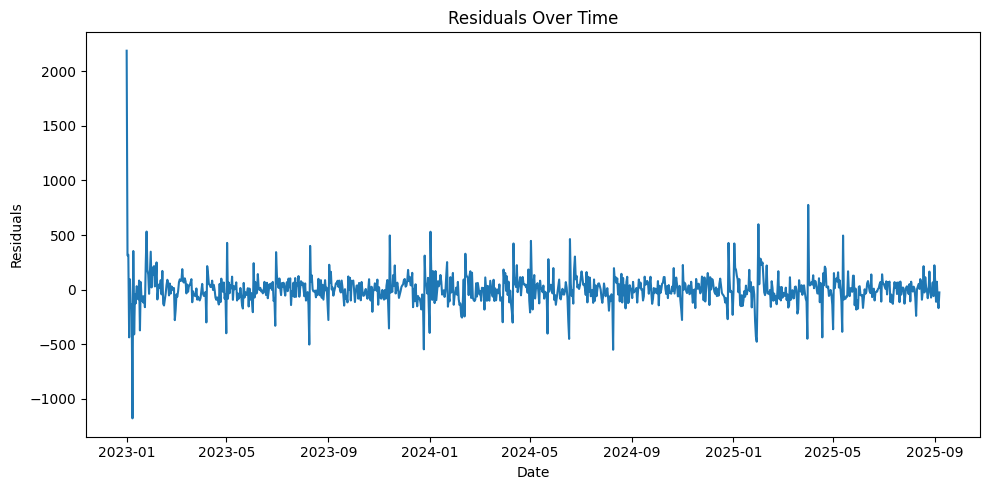

In [139]:
# Plotting Residual over time 

baseline_residuals = results.resid
plt.figure(figsize=(10,5))
plt.plot(baseline_residuals)
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

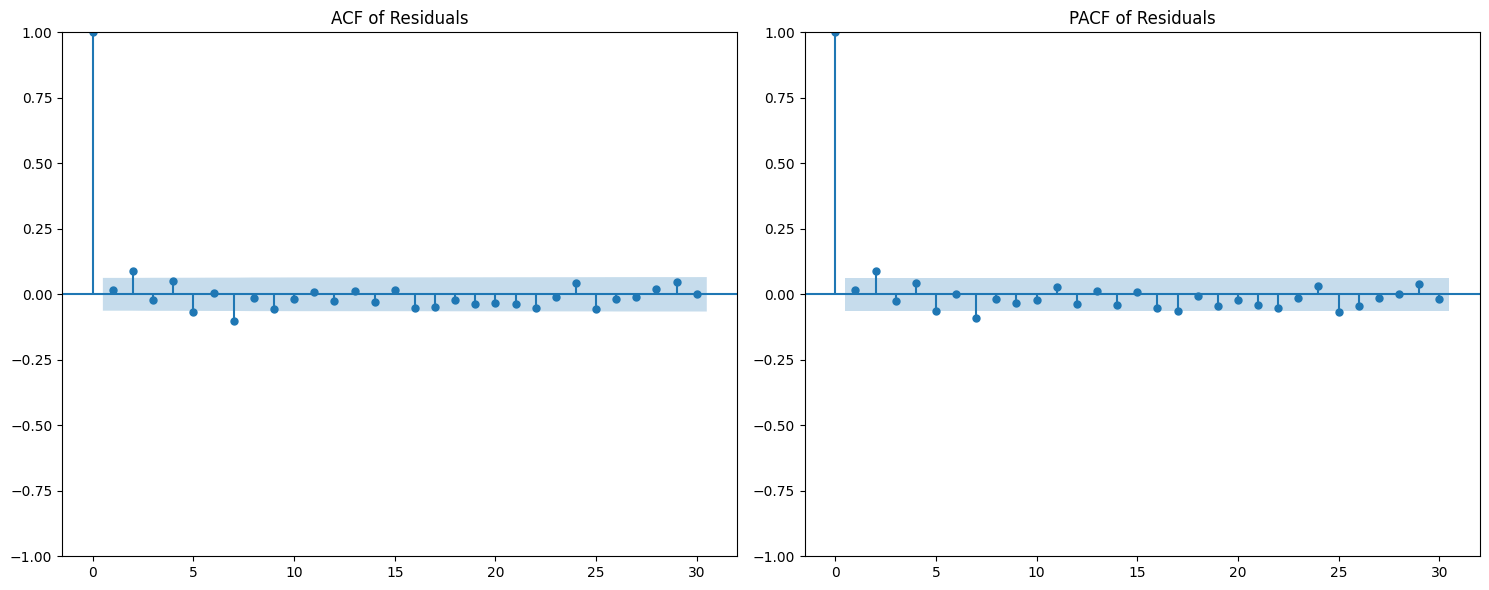

In [140]:
# Plotting ACF and PACF of Residuals
fig, ax = plt.subplots(nrows=1,
                       ncols=2,
                       figsize=(15,6))
plot_acf(baseline_residuals,
         ax=ax[0],
         alpha=0.05)
ax[0].set_title("ACF of Residuals")
plot_pacf(baseline_residuals,
          ax=ax[1],
          alpha=0.05)
ax[1].set_title("PACF of Residuals")
plt.tight_layout()
plt.show()

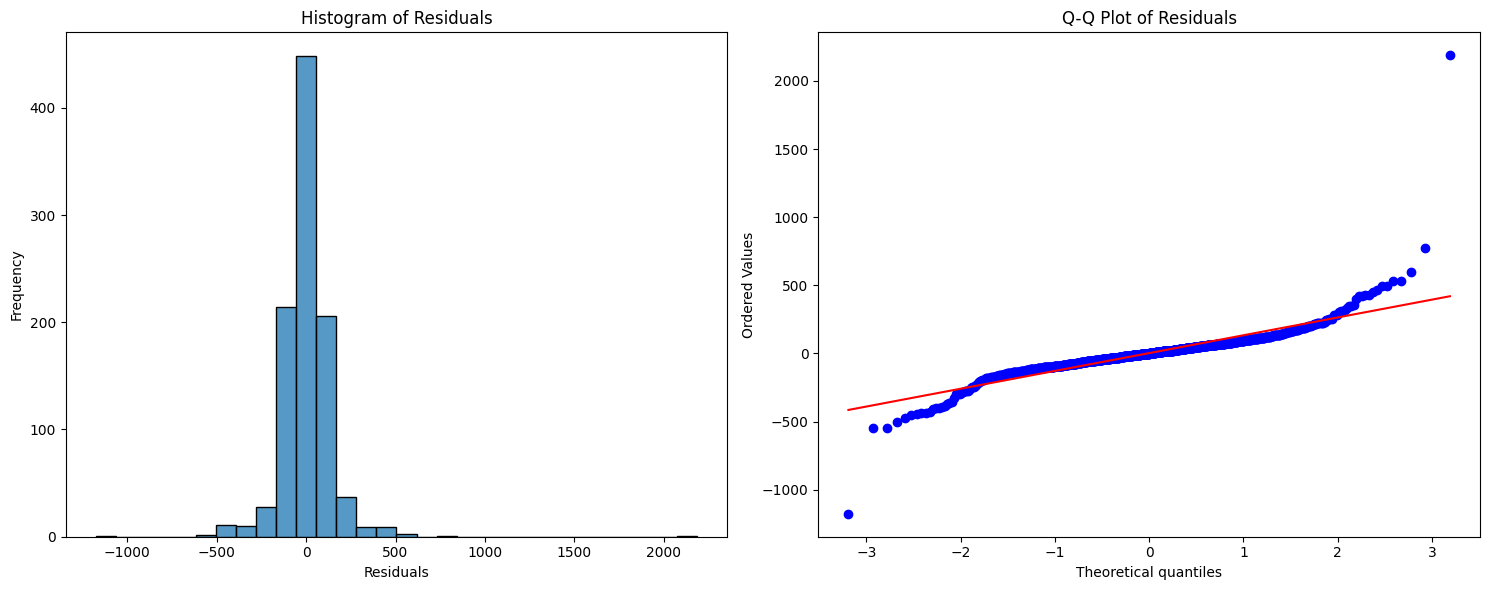

In [141]:
# Plotting Histogram and Q-Q plot of Residuals
fig, ax = plt.subplots(nrows=1,
                       ncols=2,
                       figsize=(15,6))
# Histogram
sns.histplot(baseline_residuals,
             bins=30,
             ax=ax[0])
ax[0].set_title("Histogram of Residuals")
ax[0].set_xlabel("Residuals")
ax[0].set_ylabel("Frequency")

# Q-Q plot
stats.probplot(baseline_residuals,
               dist="norm",
               plot=ax[1])
ax[1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

In [142]:
# Checking Ljung-Box test results

lb_test = acorr_ljungbox(baseline_residuals,
                        lags=[10],
                        return_df=True)
print(lb_test)


      lb_stat  lb_pvalue
10  29.218027   0.001149


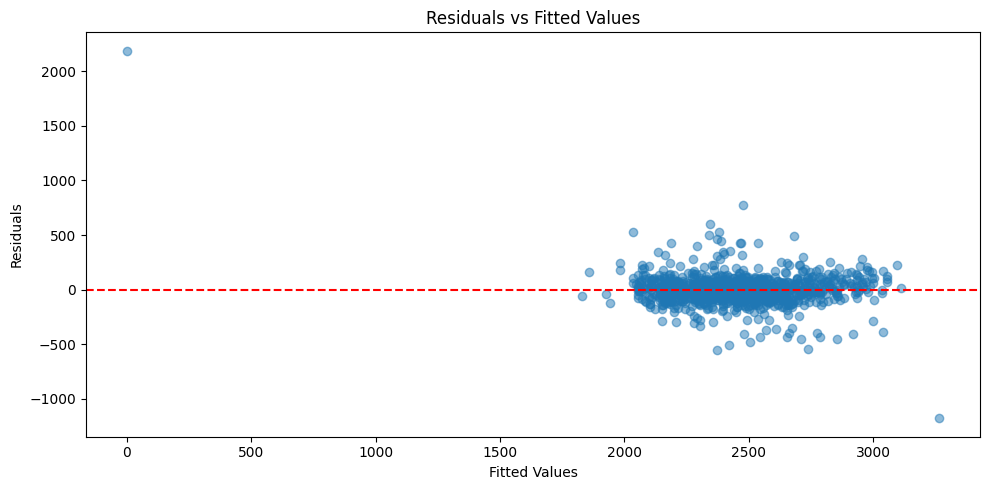

In [143]:
# Plotting our Residuals vs fitted values

plt.figure(figsize=(10,5))
plt.scatter(results.fittedvalues, baseline_residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values") 
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

## Tuned SARIMAX Model

In [144]:
# Parameter Tuning using auto_arima

auto_model = pm.auto_arima(ts_data,
                           start_p=0,
                           start_q=0,
                           max_p=3,
                           max_q=3,
                           seasonal=True,
                           m=7,
                           start_P=0,
                           start_Q=0,
                           max_P=2,
                           max_Q=2,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=14090.150, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=12931.392, Time=0.49 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=14088.150, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=14007.327, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=12766.378, Time=1.69 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=13033.401, Time=1.12 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=12677.772, Time=2.25 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=12848.741, Time=0.39 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.84 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(3,1,0)(2,0,0)[7] intercept   : AIC=12639.606, Time=2.44 sec
 ARIMA(3,1,0)(1,0,0)[7] intercept   : AIC=12816.6

In [145]:
# Fit SARIMAX with best auto_arima parameters

best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order

model =  SARIMAX(ts_data,
                order=best_order,
                seasonal_order=best_seasonal_order)

results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:            Total_Daily_Attendance   No. Observations:                  980
Model:             SARIMAX(3, 1, 0)x(2, 0, 0, 7)   Log Likelihood               -6312.806
Date:                           Mon, 22 Sep 2025   AIC                          12637.611
Time:                                   17:34:39   BIC                          12666.931
Sample:                               01-01-2023   HQIC                         12648.766
                                    - 09-06-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6986      0.021    -32.914      0.000      -0.740      -0.657
ar.L2         -0.4268      0.035    -12.117

Next 7 days forecasted attendance:
2025-09-07    2432.017786
2025-09-08    3016.561760
2025-09-09    2615.169067
2025-09-10    2599.870333
2025-09-11    2515.118453
2025-09-12    2437.343213
2025-09-13    2260.253961
Freq: D, Name: predicted_mean, dtype: float64
The total forecasted attendance for the next 7 days is: 17876


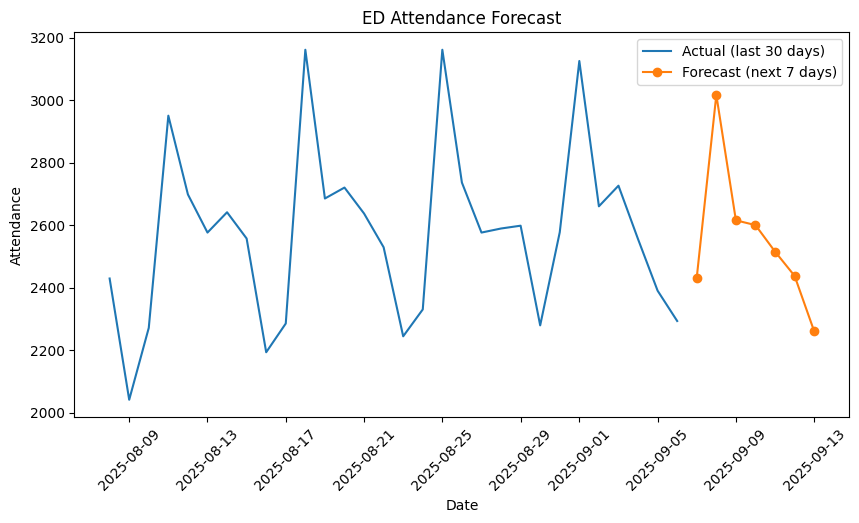

In [146]:
# Checking the forecast for the next 7 days with the tuned model

tuned_forecast = results.get_forecast(steps=7)
tuned_predicted = tuned_forecast.predicted_mean

print("Next 7 days forecasted attendance:")
print(tuned_predicted)
print(f"The total forecasted attendance for the next 7 days is: {tuned_predicted.sum():.0f}")

# Plot actual vs forecast
plt.figure(figsize=(10,5))
plt.plot(ts_data[-30:], label="Actual (last 30 days)")
plt.plot(tuned_predicted, label="Forecast (next 7 days)", marker='o')
plt.legend()
plt.title("ED Attendance Forecast")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Attendance")
plt.show()

In [147]:
# RMSE and MAE for the tuned model
tuned_actual = ts_data[-7:]
tuned_mae = mean_absolute_error(tuned_actual, tuned_predicted)
tuned_rmse = calculate_rmse(tuned_actual, tuned_predicted)

print(f"MAE: {tuned_mae:.2f}")
print(f"RMSE: {tuned_rmse:.2f}")

MAE: 77.76
RMSE: 89.12


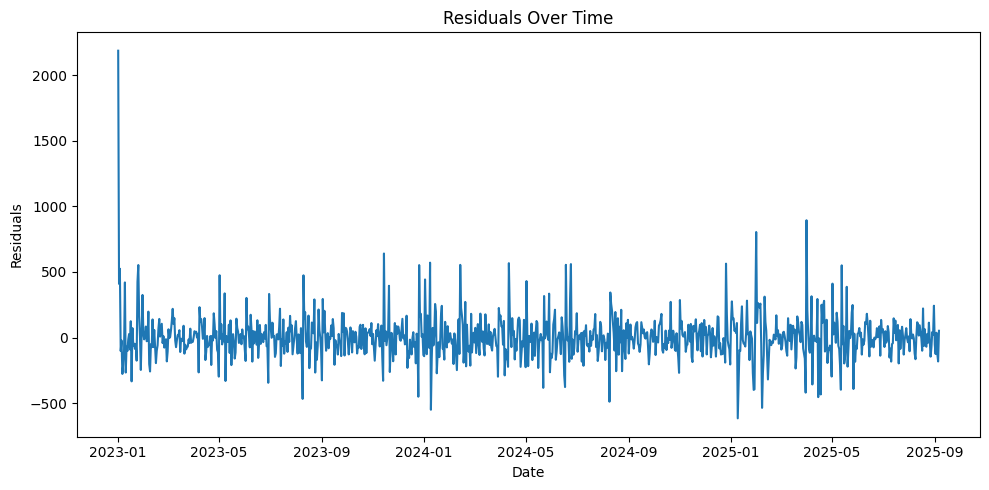

In [148]:
# Plotting Residual over time

tuned_residuals = results.resid
plt.figure(figsize=(10,5))
plt.plot(tuned_residuals)
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

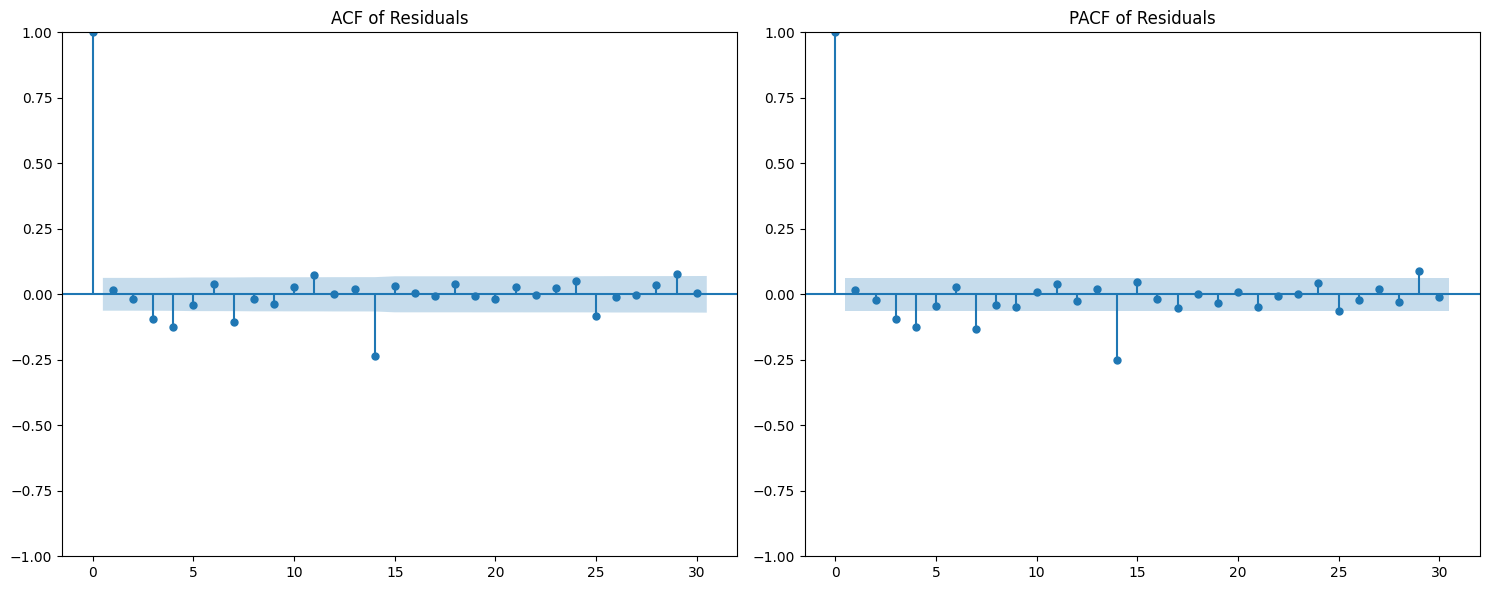

In [149]:
# Plotting ACF and PACF of Residuals for tuned model
fig, ax = plt.subplots(nrows=1,
                       ncols=2,
                       figsize=(15,6))
plot_acf(tuned_residuals,
         ax=ax[0],
         alpha=0.05)
ax[0].set_title("ACF of Residuals")
plot_pacf(tuned_residuals,
          ax=ax[1],
          alpha=0.05)
ax[1].set_title("PACF of Residuals")
plt.tight_layout()
plt.show()

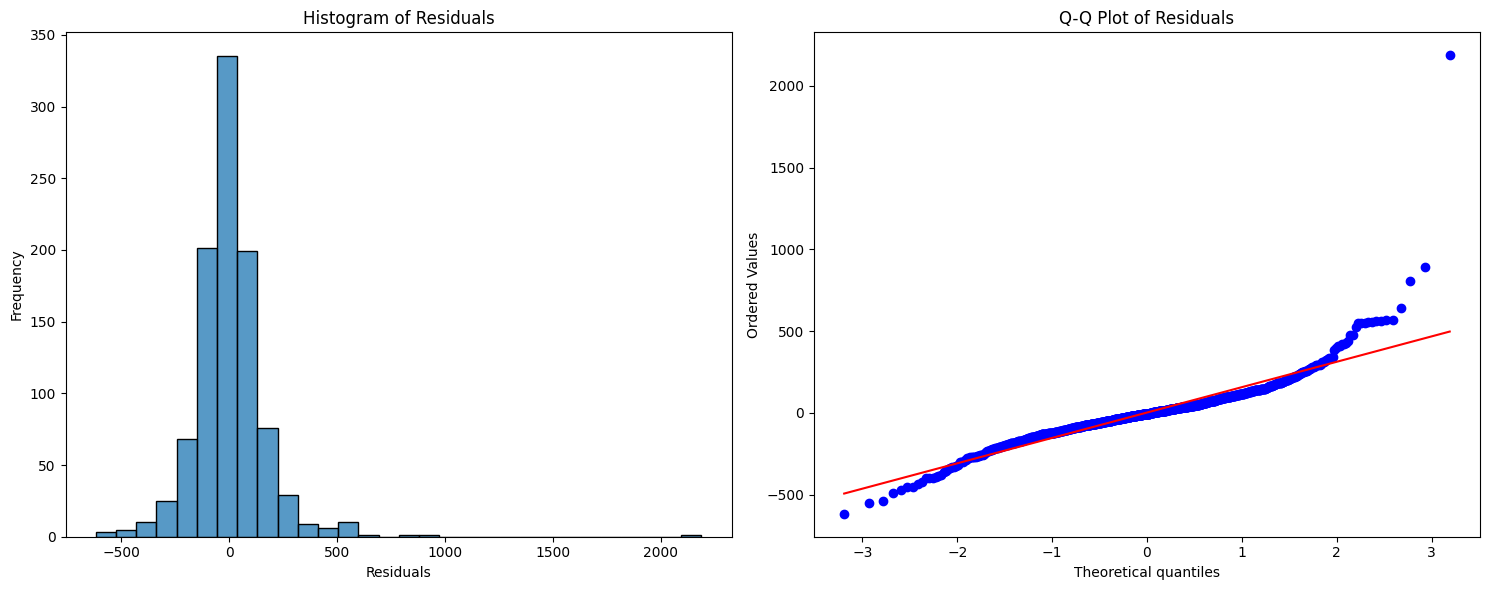

In [150]:
# Plotting Histogram and Q-Q plot of Residuals
fig, ax = plt.subplots(nrows=1,
                       ncols=2,
                       figsize=(15,6))
# Histogram
sns.histplot(tuned_residuals,
             bins=30,
             ax=ax[0])
ax[0].set_title("Histogram of Residuals")
ax[0].set_xlabel("Residuals")
ax[0].set_ylabel("Frequency")

# Q-Q plot
stats.probplot(tuned_residuals,
               dist="norm",
               plot=ax[1])
ax[1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

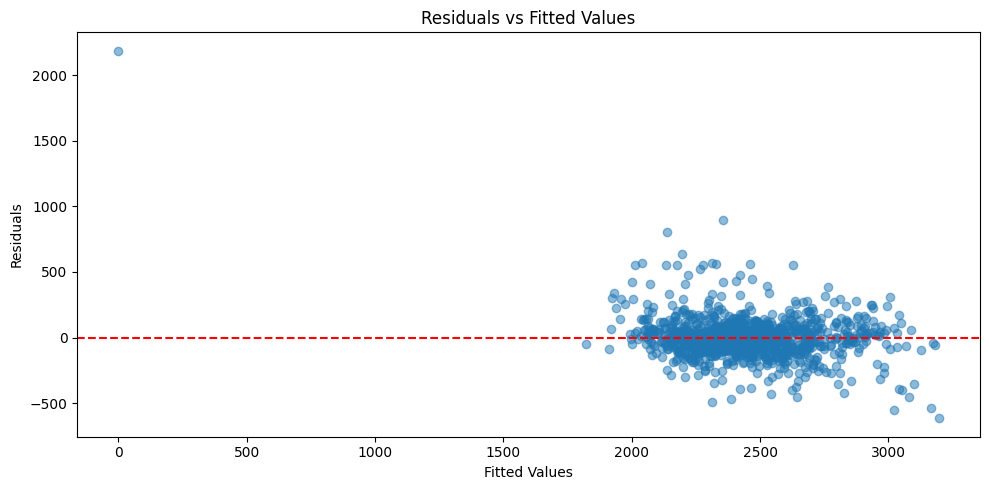

In [151]:
# Plotting our Residuals vs fitted values

plt.figure(figsize=(10,5))
plt.scatter(results.fittedvalues, tuned_residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values") 
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

In [152]:
def model_comparison_summary(baseline_mae, baseline_rmse, tuned_mae, tuned_rmse):
    """
    Prints a summary table comparing baseline and tuned SARIMAX model performance.
    """
    print("Model Comparison Summary")
    print("-" * 30)
    print(f"{'Model':<12}{'MAE':>10}{'RMSE':>10}")
    print(f"{'Baseline':<12}{baseline_mae:>10.2f}{baseline_rmse:>10.2f}")
    print(f"{'Tuned':<12}{tuned_mae:>10.2f}{tuned_rmse:>10.2f}")
    print("-" * 30)
    improvement_mae = baseline_mae - tuned_mae
    improvement_rmse = baseline_rmse - tuned_rmse
    print(f"MAE Improvement: {improvement_mae:.2f}")
    print(f"RMSE Improvement: {improvement_rmse:.2f}")

# Example usage:
model_comparison_summary(baseline_mae, baseline_rmse, tuned_mae, tuned_rmse)

Model Comparison Summary
------------------------------
Model              MAE      RMSE
Baseline         99.15    115.25
Tuned            77.76     89.12
------------------------------
MAE Improvement: 21.39
RMSE Improvement: 26.12


## Exogenous Variable Integration

In [153]:
holidays = pd.read_csv("../data/singapore_public_holidays_2023_2025.csv")

# Create columns [isHoliday]
data["IsHoliday"] = data["Date"].isin(holidays["date"]).astype(int)

# Check to see if the dates are identified properly
print(data[["Date", "IsHoliday"]].head(10))
print(f"Total holidays flagged: {data['IsHoliday'].sum()}")

        Date  IsHoliday
0 2023-01-01          1
1 2023-01-02          0
2 2023-01-03          0
3 2023-01-04          0
4 2023-01-05          0
5 2023-01-06          0
6 2023-01-07          0
7 2023-01-08          0
8 2023-01-09          0
9 2023-01-10          0
Total holidays flagged: 31


In [157]:
# Add common ED exogenous variable

# After holiday: 1 if previous day is a holiday, else 0
data["AfterHoliday"] = data["IsHoliday"].shift(1, fill_value=0)
print(data["AfterHoliday"].head(10))

# Long weekend: 1 if holiday falls on Friday or Monday, or Sat/Sun adjacent to holiday, else 0
data["IsLongWeekend"] = (
    ((data["IsHoliday"] == 1) & (data["DayOfWeek"].isin([0, 4]))) |  # Monday or Friday holiday
    ((data["IsHoliday"].shift(-1, fill_value=0) == 1) & (data["DayOfWeek"] == 6)) |  # Sunday before holiday
    ((data["IsHoliday"].shift(1, fill_value=0) == 1) & (data["DayOfWeek"] == 5))    # Saturday after holiday
).astype(int)

# Monday Peak: 1 if Monday, else 0
data["IsMonday"] = (data["DayOfWeek"] == 0).astype(int)

print(data[["Date", "IsHoliday", "AfterHoliday", "IsLongWeekend", "IsMonday"]].head(10))


0    0
1    1
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: AfterHoliday, dtype: int64
        Date  IsHoliday  AfterHoliday  IsLongWeekend  IsMonday
0 2023-01-01          1             0              0         0
1 2023-01-02          0             1              0         1
2 2023-01-03          0             0              0         0
3 2023-01-04          0             0              0         0
4 2023-01-05          0             0              0         0
5 2023-01-06          0             0              0         0
6 2023-01-07          0             0              0         0
7 2023-01-08          0             0              0         0
8 2023-01-09          0             0              0         1
9 2023-01-10          0             0              0         0


In [159]:
# Preparing exogenous variable (holiday) for SARIMAX model

exog_vars = ["IsHoliday", "AfterHoliday", "IsLongWeekend", "IsMonday"]
exog = data.set_index('Date')[exog_vars]

# Fit SARIMAX with exogenous variables
model = SARIMAX(ts_data,
                order=best_order,
                seasonal_order=best_seasonal_order,
                exog=exog)
exog_results = model.fit(disp=False)
print(exog_results.summary())

                                     SARIMAX Results                                     
Dep. Variable:            Total_Daily_Attendance   No. Observations:                  980
Model:             SARIMAX(3, 1, 0)x(2, 0, 0, 7)   Log Likelihood               -6073.393
Date:                           Mon, 22 Sep 2025   AIC                          12166.786
Time:                                   17:42:51   BIC                          12215.652
Sample:                               01-01-2023   HQIC                         12185.378
                                    - 09-06-2025                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
IsHoliday      -236.7530     14.741    -16.060      0.000    -265.645    -207.861
AfterHoliday    207.1225     10.04

In [161]:
# Forecast the next 7 days with exogenous variables
exog_next7 = exog[-7:]
exog_forecast = exog_results.get_forecast(steps=7, exog=exog_next7)
exog_predicted = exog_forecast.predicted_mean

print("Next 7 days forecasted attendance (with exogenous variables):")
print(exog_predicted)
print(f"Total forecasted attendance for next 7 days: {exog_predicted.sum():.0f}")

Next 7 days forecasted attendance (with exogenous variables):
2025-09-07    2418.248867
2025-09-08    3063.926717
2025-09-09    2608.851962
2025-09-10    2584.081771
2025-09-11    2509.901280
2025-09-12    2442.170929
2025-09-13    2265.769547
Freq: D, Name: predicted_mean, dtype: float64
Total forecasted attendance for next 7 days: 17893
